In [0]:
# DF es el dataframe agrupado por año y mes

import pandas as pd
import numpy as np

# agarrar la tabla del container
df = spark.read.csv(
    "/mnt/data_lake/SandBox/DataAnalytics/jaime_figueroa/TAM/RawData/TablaDQUAPIB", 
    header=True, 
    inferSchema=True,
    lineSep="\n")

# convertir la tabla en pandas
df = df.toPandas()

# la tabla tiene un nombre inusual en la útlima columna. aquí lo cambiamos a Lag3
df.rename(columns={'Lag3\r':'Lag3'}, inplace=True)

# creamos una función para agregar una columna de trimestre con label de string
def trimestre(df):
  if df['MONTH'] <= 3:
    return 'T1'
  elif df['MONTH'] >= 4 and df['MONTH'] <= 6:
    return 'T2'
  elif df['MONTH'] >= 7 and df['MONTH'] <= 9:
    return 'T3'
  else:
    return 'T4'

# creamos una función para agregar una columna de trimestre con label numérico
def trimestre2(df):
  if df['MONTH'] <= 3:
    return 1
  elif df['MONTH'] >= 4 and df['MONTH'] <= 6:
    return 2
  elif df['MONTH'] >= 7 and df['MONTH'] <= 9:
    return 3
  else:
    return 4
  
# usamos las funciones para agregar las variables nuevas
df['Trimestre'] = df.apply(trimestre, axis=1)
df['Trimestre2'] = df.apply(trimestre2, axis=1)

# creamos el valor de MXPAD para asignar a cada año
MXPAD11 = [21763]
MXPAD12 = [23035]
MXPAD13 = [23449]
MXPAD14 = [24039]
MXPAD15 = [24552]
MXPAD16 = [23748]
MXPAD17 = [17894]
MXPAD18 = [17946]
MXPAD19 = [15638]
MXPAD20 = [13841]
MXPAD21 = [7893]

# lo multiplicamos por 12 para que haya una instancia por mes del año. MXPAD21 son solamente 6 meses
MXPAD11 = MXPAD11*12
MXPAD12 = MXPAD12*12
MXPAD13 = MXPAD13*12
MXPAD14 = MXPAD14*12
MXPAD15 = MXPAD15*12
MXPAD16 = MXPAD16*12
MXPAD17 = MXPAD17*12
MXPAD18 = MXPAD18*12
MXPAD19 = MXPAD19*12
MXPAD20 = MXPAD20*12
MXPAD21 = MXPAD21*6

# los unimos para poder agregar la columna a la tabla
MXPAD = MXPAD11 + MXPAD12 + MXPAD13 + MXPAD14 + MXPAD15 + MXPAD16 + MXPAD17 + MXPAD18 + MXPAD19 + MXPAD20 + MXPAD21

# creamos un df4 para hacer los cambios necesarios
df4 = df
# porcentaje de ratio tomando todos los meses agrupados y dividiendo por cantidad total vendida
mylist = list((df.groupby('MONTH').sum()['DQUA'] / df['DQUA'].sum()))
# multiplicar para tener la misma cantidad de años
mylist2 = mylist*10
# agregarle los 6 meses de final de la tabla
mylist3 = mylist2 + mylist[0:6]
# agregar la columna de porcentaje promedio por mes con todos los años
df4['%meanYear'] = mylist3

#######

# agrupar por año y mantener el año como índice
years_sum = df.groupby('YEAR').sum()['DQUA'].reset_index()
# conseguir el dqua del año
years_sum[years_sum['YEAR']==2011]['DQUA']
# agrupar por año para tener suma de dqua
a = df.groupby(['YEAR']).agg(DQUA_2=('DQUA','sum'))
# unir las sumas con el df
df4 = df.join(a,on='YEAR')
# crear columna de porcentaje por mes por año
df4['%porYear'] = (df4['DQUA'] / df4['DQUA_2'])
# quitar la columna de dqua_2 que habíamos creado
df4.drop('DQUA_2',axis=1,inplace=True)

######

# agregar columna de TAM para poder dividir
df4['TAM'] = MXPAD

######

# ver resultado final
df4['TAM1PromMesGlob'] = (df4['TAM'] * df4['%meanYear']).round()
df4['TAM2PromMesAn'] = (df4['TAM'] * df4['%porYear']).round()

# tabla final con las cantidades de TAM
df5 = df4.drop(['TAM', '%meanYear', '%porYear'],axis=1)
#df5.head()

Out[1]:

,YEAR,MONTH,DQUA,TasaDeCambio,CPIMex,Intereses,IGAE,CETES,GasolinaRegular,GasolinaPremium,CPIGas,Cobre,Aluminio,TexOil,GasNatural,Acero,EMBI,ElectricGenTransDist,RegistroRUV,VerificacionRUV,ProduccionRUV,PIBMex,PIBForFish,PIBConstr,PIBExtract,PIBManuf,PIBBev,PIBUtil,PIBElec,PIBServ,Lag12,Lag6,Lag3,Trimestre,Trimestre2,TAM1PromMesGlob,TAM2PromMesAn
0,2011,1,54.0,12.1,75.3,4.9,93.4,4.1,8.84,10.14,53.6,9555.0,2439.0,89.4,4.5,728.2,130.6,73.9,25395.27,22263.97,20575.54,86.06,2.72,6.51,4.04,15.26,3.88,1.32,1.02,51.55,73.0,63.0,89.0,T1,1,1805.0,403.0
1,2011,2,86.0,12.1,75.6,4.9,93.5,4.0,8.92,10.18,53.9,9867.0,2508.0,89.6,4.1,810.2,133.0,74.8,25193.89,22052.76,20575.13,86.06,2.72,6.51,4.04,15.26,3.88,1.32,1.02,51.55,73.0,38.0,167.0,T1,1,1776.0,641.0
2,2011,3,169.0,12.0,75.7,4.9,94.1,4.3,9.00,10.22,54.4,9530.0,2552.0,102.9,4.0,873.0,132.0,76.0,25060.77,21933.48,20508.80,86.06,2.72,6.51,4.04,15.26,3.88,1.32,1.02,51.55,92.0,107.0,112.0,T1,1,2241.0,1260.0
3,2011,4,55.0,11.7,75.7,4.9,93.6,4.3,9.08,10.26,55.0,9483.0,2662.0,110.0,4.2,847.0,134.1,73.0,25000.70,21876.70,20415.99,86.51,2.52,6.73,4.08,15.21,3.89,1.34,1.03,51.73,41.0,89.0,54.0,T2,2,1814.0,410.0
4,2011,5,138.0,11.7,75.2,4.9,94.5,4.3,9.16,10.30,55.2,8926.0,2592.0,101.3,4.3,789.6,140.7,71.6,24881.67,21755.70,20344.41,86.51,2.52,6.73,4.08,15.21,3.89,1.34,1.03,51.73,98.0,167.0,86.0,T2,2,1566.0,1029.0


In [0]:
# quitar columnas que no queremos estandardizar
df6 = df5.drop(['Trimestre', 'YEAR', 'MONTH', 'TAM1PromMesGlob', 'TAM2PromMesAn', 'DQUA'], axis=1)

# import library necesaria para el proceso
from sklearn.preprocessing import MaxAbsScaler

# crear instancia de Scaler
abs_scaler = MaxAbsScaler()

# hacer el fit de los datos
abs_scaler.fit(df6)

# transformar los datos
scaled_data = abs_scaler.transform(df6)

# regresarlo a un dataframe
dfScaled = pd.DataFrame(scaled_data, columns = df6.columns)

# volver a agregar columnas que habíamos quitado para no estandardizar
dfScaled['YEAR'] = df5['YEAR']
dfScaled['MONTH'] = df5['MONTH']
dfScaled['TAM1PromMesGlob'] = df5['TAM1PromMesGlob']
dfScaled['TAM2PromMesAn'] = df5['TAM2PromMesAn']
dfScaled['DQUA'] = df5['DQUA']

# cambiar el orden de las columnas de la tabla
dfScaled = dfScaled[['YEAR', 'MONTH', 'DQUA', 'TAM1PromMesGlob', 'TAM2PromMesAn', 'TasaDeCambio', 'CPIMex', 'Intereses', 'IGAE', 'CETES', 'GasolinaRegular', 'GasolinaPremium', 'CPIGas', 'Cobre', 'Aluminio', 'TexOil', 'GasNatural',	'Acero', 'EMBI', 'ElectricGenTransDist', 'RegistroRUV', 'VerificacionRUV', 'ProduccionRUV',	'PIBMex', 'PIBForFish',	'PIBConstr', 'PIBExtract', 'PIBManuf', 'PIBBev', 'PIBUtil', 'PIBElec', 'PIBServ', 'Lag12', 'Lag6', 'Lag3', 'Trimestre2']]

dfScaled.head()

Out[14]:

,YEAR,MONTH,DQUA,TAM1PromMesGlob,TAM2PromMesAn,TasaDeCambio,CPIMex,Intereses,IGAE,CETES,GasolinaRegular,GasolinaPremium,CPIGas,Cobre,Aluminio,TexOil,GasNatural,Acero,EMBI,ElectricGenTransDist,RegistroRUV,VerificacionRUV,ProduccionRUV,PIBMex,PIBForFish,PIBConstr,PIBExtract,PIBManuf,PIBBev,PIBUtil,PIBElec,PIBServ,Lag12,Lag6,Lag3,Trimestre2
0,2011,1,54.0,1805.0,403.0,0.500000,0.666372,0.569767,0.822907,0.493976,0.435468,0.458824,0.424386,0.938236,0.916228,0.812727,0.750000,0.437804,0.327154,0.678604,0.301474,0.249904,0.629491,0.821968,0.770538,0.865691,0.973494,0.819109,0.810021,0.809816,0.790698,0.788106,0.105491,0.091040,0.128613,0.25
1,2011,2,86.0,1776.0,641.0,0.500000,0.669027,0.569767,0.823789,0.481928,0.439409,0.460633,0.426762,0.968873,0.942149,0.814545,0.683333,0.487104,0.333166,0.686869,0.299083,0.247534,0.629478,0.821968,0.770538,0.865691,0.973494,0.819109,0.810021,0.809816,0.790698,0.788106,0.105491,0.054913,0.241329,0.25
2,2011,3,169.0,2241.0,1260.0,0.495868,0.669912,0.569767,0.829075,0.518072,0.443350,0.462443,0.430721,0.935782,0.958678,0.935455,0.666667,0.524860,0.330661,0.697888,0.297503,0.246195,0.627449,0.821968,0.770538,0.865691,0.973494,0.819109,0.810021,0.809816,0.790698,0.788106,0.132948,0.154624,0.161850,0.25
3,2011,4,55.0,1814.0,410.0,0.483471,0.669912,0.569767,0.824670,0.518072,0.447291,0.464253,0.435471,0.931167,1.000000,1.000000,0.700000,0.509229,0.335922,0.670340,0.296790,0.245557,0.624610,0.826266,0.713881,0.894947,0.983133,0.816425,0.812109,0.822086,0.798450,0.790858,0.059249,0.128613,0.078035,0.50
4,2011,5,138.0,1566.0,1029.0,0.483471,0.665487,0.569767,0.832599,0.518072,0.451232,0.466063,0.437055,0.876473,0.973704,0.920909,0.716667,0.474719,0.352455,0.657484,0.295377,0.244199,0.622420,0.826266,0.713881,0.894947,0.983133,0.816425,0.812109,0.822086,0.798450,0.790858,0.141618,0.241329,0.124277,0.50


In [0]:
# lo requerido para correr el modelo
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# escogemos las variables del modelo
x = dfScaled[['CPIMex', 'CETES', 'TexOil', 'GasNatural', 'EMBI', 'ElectricGenTransDist', 'ProduccionRUV', 'PIBManuf', 'PIBElec', 'Trimestre2']]

# se escoge la columna que queremos predecir
#y = df5['TAM2PromMesAn']
y = dfScaled['TAM1PromMesGlob']

# hacer el split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

# se crea una instancia del modelo
LR = LinearRegression()

# hacemos un fit con la training data
LR.fit(x_train, y_train)

# se hacen predicciones en los datos de prueba
y_prediction =  LR.predict(x_test)

# encontramos las métricas de evaluación de modelo. estas mismas métricas están en los comentarios de cada prueba de modelo en esta misma celda
r2=r2_score(y_test,y_prediction)
MAE = mean_absolute_error(y_test, y_prediction)
MAPE = mean_absolute_percentage_error(y_test, y_prediction)
print('R2: ',r2)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_prediction)))
print('MAE: '+ str(MAE))
print('MAPE: ' + str(MAPE*100))

R2: 0.73377175468551
RMSE: 221.3918860833295
MAE: 172.317401833042
MAPE: 11.20547620551244

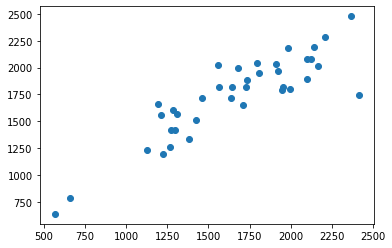

In [0]:
# import libraries necesarias y ver valor contra predicción
from matplotlib import pyplot as plt
plt.scatter(y_test, y_prediction);

In [0]:
# coeficientes del modelo
LR.coef_

Out[13]: array([-8601.40441232, -557.91130799, -1071.85203323, -319.44190212,
 -441.21237098, 3470.37129001, 444.85113828, 1189.9777836 ,
 2286.88560531, 217.74757463])